# Tutorial: Spin-based Hamiltonians 

## Introduction
The Model Hamiltonian Package is a software tool designed to generate 0, 1, and 2 electron integrals for various quantum models. In this tutorial, we'll focus on generating integrals for the Heisenberg model, specifically the XXZ Heisenberg model.

## XXZ Heisenberg Model
The XXZ Heisenberg model is a quantum model that describes the interaction between spins on a lattice. The Hamiltonian for the XXZ Heisenberg model is given by:

$$\hat{H}_{X X Z}=\sum_p\left(\mu_p^Z-J_{p p}^{\mathrm{eq}}\right) S_p^Z+\sum_{pq} J_{p q}^{\mathrm{ax}} S_p^Z S_q^Z+\sum_{pq} J_{p q}^{\mathrm{eq}} S_p^{+} S_q^{-}$$

where $S_p^Z$ is the $z$ component of the spin operator at site $p$, $S_p^{+}$ and $S_p^{-}$ are the spin raising and lowering operators at site $p$, $\mu_p^Z$ is the magnetic field at site $p$,  $J_{p q}^{\mathrm{ax}}$ is the axial exchange coupling between spins at site $p$ and $q$, and $J_{p q}^{\mathrm{eq}}$ is the equatorial exchange coupling between spins at site $p$ and $q$.

## Defining Heisenberg Model
There are two ways to define the Heisenberg model using the Model Hamiltonian Package:
1. Using the connectivity of the lattice and providing the exchange couplings, $J^{ax}$, $J^{eq}$ , and $\mu$ as a float numbers;
2. Providing exchange couplings, $J^{ax}$, $J^{eq}$ , and $\mu$ explicitly as numpy arrays;


In [1]:
# import libraries
import numpy as np
from moha import HamHeisenberg

# Defining the Hamiltonian using connectivity matrix
# For example, consider 6x6 lattice with periodic boundary condition

# Define the connectivity matrix
connectivity = np.array([[0, 1, 0, 0, 0, 1],
                          [1, 0, 1, 0, 0, 0],
                          [0, 1, 0, 1, 0, 0],
                          [0, 0, 1, 0, 1, 0],
                          [0, 0, 0, 1, 0, 1],
                          [1, 0, 0, 0, 1, 0]])

# Define the Hamiltonian parameters
J_eq = 1
J_ax = 0.5
mu = 0

# Define the Hamiltonian
ham = HamHeisenberg(connectivity=connectivity, J_eq=J_eq, J_ax=J_ax, mu=mu)

In [2]:
# Second choice: Define the Hamiltonian 
# by providing exchange couplings, $J^{ax}$ $J^{eq}$ , and $\mu$ as numpy arrays

# For example, consider 4x4 lattice with periodic boundary condition
J_eq = np.array([[0, 1, 0, 1],
                 [1, 0, 1, 0],
                 [0, 1, 0, 1],
                 [1, 0, 1, 0]])
J_ax = np.array([[0, 0.5, 0, 0.5],
                [0.5, 0, 0.5, 0],
                [0, 0.5, 0, 0.5],
                [0.5, 0, 0.5, 0]])
mu = np.zeros(4)

# Define the Hamiltonian
ham = HamHeisenberg(J_eq=J_eq, J_ax=J_ax, mu=mu)

## Generating Integrals
The Model Hamiltonian Package can generate 0, 1, and 2 electron integrals for the XXZ Heisenberg model. The integrals are stored in a sparse matrix format, and can be used to solve the Schrödinger equation for the model.
Specifically, the integrals support the following operations:
1. Get the 0, 1, and 2 electron integrals for the XXZ Heisenberg model;
2. Return intergrals in the form of a sparse or dense matrix;
3. Return integrals in a spin orbital or spatial basis; 

   __Note__ : Assumption is alpha and beta spinorbitals are the same;
4. Support 1-, 2-, and 4 - fold symmetry such as:

    a. 1-fold symmetry: no symmetry;
    
    b. 2-fold symmetry: 
    
    $$g_{ij,kl} = g_{kl,ij}$$

    c. 4-fold symmetry: 
    
    $$g_{ij,kl} = g_{kl,ij} = g_{ji,lk} = g_{lk,ji} $$

    

In [3]:
# Example: generating XXZ Heisenberg model 
# Returning electron integrals in a spatial orbital basis
# Assuming 4-fold symmetry
# Returning output as dense matrix

e0 = ham.generate_zero_body_integral()
h1 = ham.generate_one_body_integral(dense=True, basis='spatial basis') 
h2 = ham.generate_two_body_integral(dense=True, basis='spatial basis', sym=4)

print("Zero energy: ", e0)
print("One body integrals in spatial basis: \n", h1)
print("Shape of two body integral in spatial basis: ", h2.shape)
print("-"*60)

# Example: generating XXZ Heisenberg model in spin orbital basis
# Assuming 4-fold symmetry
# Returning output as dense matrix

h1 = ham.generate_one_body_integral(dense=True, basis='spinorbital basis')
h2 = ham.generate_two_body_integral(dense=True, basis='spinorbital basis', sym=4)

print("One body integrals in spin basis: \n", h1)
print("Shape of two body integral in spinorbital basis: ", h2.shape)

Zero energy:  0.5
One body integrals in spatial basis: 
 [[-0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]
Shape of two body integral in spatial basis:  (4, 4, 4, 4)
------------------------------------------------------------
One body integrals in spin basis: 
 [[-0.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.25  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.25]]
Shape of two body integral in spinorbital basis:  (8, 8, 8, 8)


/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


# Testing XXZ Heisenberg model

To test the ouput of the ModelHamiltoian package, we can solve the Schrödinger equation using Full CI algorithm for the XXZ Heisenberg model using the generated integrals. 

To do this, we will use `pyscf` package.

We can compare results with the explicit constraction of the hamiltonian matrix using pauli matrices. 
The explicit construction of the hamiltonian matrix is given by:

$$\mathcal{H}_{X X Z}=\sum_{m=0}^{L-1}\left\{J^{eq}\left(S_x^{(m)} S_x^{(m+1)}+S_y^{(m)} S_y^{(m+1)}\right)+ J^{ax} S_z^{(m)} S_z^{(m+1)}\right\}$$


To construct spin operators on the site $m$, we can use the following relation:

$$S_i^{(m)} \equiv \frac{1}{2} \overbrace{\mathbb{1}_{2 \times 2} \otimes \ldots \otimes \mathbb{1}_{2 \times 2}}^m \otimes \sigma_i \otimes \overbrace{\mathbb{1}_{2 \times 2} \otimes \ldots \otimes \mathbb{1}_{2 \times 2}}^{L-m-1} .$$

Where $\sigma_i$ is the Pauli matrix $\forall i \epsilon \{x, y, z\}$.
To find the spectrum of the constructed hamiltonian matrix, we can use `numpy` package.

In [4]:
# Constructing the XXZ Hamiltonian explicitly
from numpy.linalg import eigh

# Define Pauli spin matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

# Define function for Kronecker product with identity
def kron_id(matrix, N, L):
  """
  Creates Kronecker product of matrix with identity matrices.

  Args:
      matrix: The matrix for Kronecker product.
      N: Number of identity matrices before the matrix.
      L: Number of sites.

  Returns:
      A Kronecker product of the matrix with identity matrices.
  """
  result = matrix
  for _ in range(N):
    result = np.kron(I, result)

  for _ in range(L-N-1):
    result = np.kron(result, I)
  return 1/2*result

# Define function to create spin operators on Nth site
def spin_operator(operator, N, L):
  """
  Creates a spin operator (Sx, Sy, Sz) on the Nth site.

  Args:
      operator: The Pauli spin matrix (sigma_x, sigma_y, sigma_z).
      N: The site index for the spin operator.
      L: Total number of sites.

  Returns:
      A Kronecker product representing the spin operator on Nth site.
  """
  return kron_id(operator, N, L)

# Define system size (number of sites)
L = 6 # Change this for different system size

# Create spin operators on each site
Sx = [spin_operator(sigma_x, i, L) for i in range(L)]
Sy = [spin_operator(sigma_y, i, L) for i in range(L)]
Sz = [spin_operator(sigma_z, i, L) for i in range(L)]

# Define Hamiltonian (only nearest-neighbor interaction for simplicity)
J_eq = 1  # Coupling constant
J_ax = 0.2
H = 0
for i in range(L):
    j = i+1
    if j == L:
        j = 0
    H += J_eq * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j]) + J_ax*(Sz[i] @ Sz[j])

# Convert explicit Hamiltonian to numpy array
H_array = np.array(H, dtype=complex)

# Calculate eigenvalues and ground state
eigenvalues, eigenvectors = eigh(H_array)

# Print ground state energy (lowest eigenvalue)
print(f"Ground state energy per electron: {eigenvalues[0]/L}")

Ground state energy per electron: -0.35649726389842357


In [5]:
from pyscf import fci

# Constructing the XXZ Hamiltonian using the HamHeisenberg class

# Define the Hamiltonian parameters
connectivity = np.zeros((L, L))
connectivity[np.arange(L-1), np.arange(L-1)+1] = 1
connectivity[0, -1] = 1
connectivity += connectivity.T

# Define the Hamiltonian
ham = HamHeisenberg(connectivity=connectivity, J_eq=1, J_ax=0.2, mu=0)
e0 = ham.generate_zero_body_integral()
h1 = ham.generate_one_body_integral(dense=True, basis='spatial basis')
h2 = ham.generate_two_body_integral(dense=True, basis='spatial basis', sym=4)

# convert h2 to chemists notation
h2_ch = np.transpose(h2, (0, 2, 1, 3))

# Calculate eigenvalues and ground state
e, ci = fci.direct_spin0.kernel(h1, h2_ch, L, L)
print(f"Ground state energy per electron: {(e+e0)/L}")

Ground state energy per electron: -0.35649726389842346


/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Testing XXX Heisenberg model

[It can be shown](https://studenttheses.uu.nl/bitstream/handle/20.500.12932/36243/thesis%20Kuijper.pdf?sequence=1&isAllowed=y) that for one dimensional XXX Heisenberg model (when $J^{eq} = J^{ax} = J$), the energy of the ground state per site in the thermodynamic limit is equal to

$$E_0 = -|J|\left(0.25 - \ln2\right)$$

In this part we will constuct 4, 6, and 8 site XXX Heisenberg model for $J = 1$ and compare the energy of the ground state per site with the theoretical value.

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


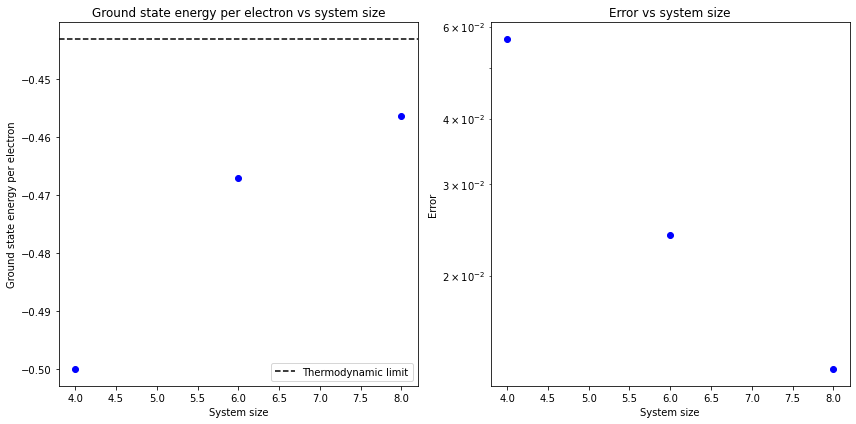

In [6]:
from matplotlib import pyplot as plt
e_inf = 0.25 - np.log(2)

# create figure with 2 plots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for L in range(4, 10, 2):
    # Define the connectivity matrix
    connectivity = np.zeros((L, L))
    connectivity[np.arange(L-1), np.arange(L-1)+1] = 1
    connectivity[0, -1] = 1
    connectivity += connectivity.T

    # Define the Hamiltonian
    ham = HamHeisenberg(connectivity=connectivity, J_eq=1, J_ax=1, mu=0)
    e0 = ham.generate_zero_body_integral()
    h1 = ham.generate_one_body_integral(dense=True, basis='spatial basis')
    h2 = ham.generate_two_body_integral(dense=True, basis='spatial basis', sym=4)

    # convert h2 to chemists notation
    h2_ch = np.transpose(h2, (0, 2, 1, 3))

    # Calculate eigenvalues and ground state
    e, ci = fci.direct_spin0.kernel(h1, h2_ch, L, L, max_memory=10000, pspace_size=20000)
    e_per_e = (e+e0)/L
    error = e_inf - e_per_e
    ax[0].plot(L, e_per_e, 'bo')
    ax[1].plot(L, error, 'bo')

# plot the thermodynamic limit
ax[0].axhline(y=e_inf, color='k', linestyle='--', label='Thermodynamic limit')

ax[0].set_xlabel('System size')
ax[0].set_ylabel('Ground state energy per electron')
ax[0].set_title('Ground state energy per electron vs system size')
# show legend
ax[0].legend()

ax[1].set_xlabel('System size')
ax[1].set_ylabel('Error')
ax[1].set_title('Error vs system size')

# set log scale for y axis on the second plot
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()

## Saving the output of the ModelHamiltonian Package

Once we have generated the integrals using Model Hamiltonian, we can save the output in a file. This will allow us to use the integrals later without regenerating them.

There are two supported file formats:
1. `.fcidump`

    In this case the integrals are saved in the FCIDUMP format. User needs to provide a TextIO file, for example `open("<filename>", 'w')`, number of electron and spinpolarization. The lates is set to 0 by default.
2. `.npz file`

    In this case the integrals are saved in .npz file format. User needs to provide a filename. Energy shift, one-, and two-electron integrals are saved under the keys `e0`, `h1` and `h2` respectively.


In [7]:
# Constructing the XXZ Hamiltonian using the HamHeisenberg class

# Define the Hamiltonian parameters
L = 4
connectivity = np.zeros((L, L))
connectivity[np.arange(L-1), np.arange(L-1)+1] = 1
connectivity[0, -1] = 1
connectivity += connectivity.T

# Define the Hamiltonian
ham = HamHeisenberg(connectivity=connectivity, J_eq=1, J_ax=0.2, mu=0)
e0 = ham.generate_zero_body_integral()
h1 = ham.generate_one_body_integral(dense=True, basis='spatial basis')
h2 = ham.generate_two_body_integral(dense=True, basis='spatial basis', sym=4)

# save the Hamiltonian to npz file
ham.savez('Heisenberg_4_site.npz')
# save the Hamiltonian to fcidump file
ham.save_fcidump(open('Heisenberg_4_site.fcidump', 'w'), L, 0)